## Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, r'E:\GitHub\smart-parking-system')

from system.detection.model import deeplab_v3
from system.classification.model import CharacterClassifier
import system.backend.utils.utils as utils

## Constants

In [2]:
detection_model_path = r'E:\GitHub\smart-parking-system\system\detection\training\experiment_v0.02\model_checkpoints\v0.02_e59_l0.125.pt'
classification_model_path = r"E:/GitHub/smart-parking-system/system/classification/training/experiment_v0.14/model_checkpoints/v0.14_e9_l0.074.pt"

## Functions

In [3]:
def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(cols), int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [4]:
def plot(img, pred, threshold=0.1):
    plt.figure(figsize=(20,20));
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(torch.squeeze(pred).cpu().numpy()>threshold)
    plt.title('Segmentation Output')
    plt.axis('off')

In [7]:
def pred(image, model_segmentare):
    preprocess = transforms.Compose([
        #transforms.Resize((320, 640)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model_segmentare(input_batch)
        return output

In [6]:
def histogram_equalization(image: Image.Image):
    """
    Apply histogram equalization to a given image.
    :param image: An image.
    :return: The image after the histogram equalization as numpy array.
    """
    # Converting the image to grayscale if not in grayscale
    '''if not image.mode == 'L':
        print(f'Image mode is \"{image.mode}\". Converting to grayscale')
        image = image.convert('L')'''

    # Convert the image to an array to be used by skimage equalization function
    image = np.array(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)

    return equalized

## License plate detection

### Load model into memory

In [8]:
model_segmentare = deeplab_v3('resnet101', 'imagenet', ['license-plate'], 'sigmoid')
checkpoint = torch.load(detection_model_path, map_location='cpu')
model_segmentare.load_state_dict(checkpoint)
model_segmentare.eval()

if torch.cuda.is_available():
    model_segmentare.to('cuda')

### Read sample and predict license plate location

In [9]:
input_sample = Image.open(r"E:\GitHub\smart-parking-system\dataset\segmentation\test\images\lpdr_sample_332.jpg").convert('RGB')

In [10]:
input_sample = input_sample.resize((640,320)) # The size required by the model, used for training

preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])

input_tensor = preprocess(input_sample)
input_batch = input_tensor.unsqueeze(0)
    
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
    output = model_segmentare(input_batch)

### Crop the license plate from the entire input image

In [11]:
# Convert from tensor to grayscale numpy array
mask = torch.squeeze(output).cpu().numpy()>0.7
mask_grayscale = np.array(Image.fromarray(mask).convert("L"))

In [12]:
# Do contour detection to find the biggest bounding box in the predict
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(mask_grayscale, kernel, iterations=1)

_, threshold = cv2.threshold(img_dilation, 127, 255, cv2.THRESH_TOZERO)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)
x, y = contours[max_area_idx].T
plate_bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))

In [13]:
plate_result = np.array(input_sample)
plate_result = plate_result[max(plate_bbox[0][1], 0) : min(plate_bbox[1][1], plate_result.shape[0]),max(plate_bbox[0][0], 0) : min(plate_bbox[1][0], plate_result.shape[1])]

In [14]:
display(Image.fromarray(plate_result))

In [15]:
plate_result = utils.image_resize(plate_result, height=256)
plate_result = utils.unsharp_mask(plate_result, amount=50)

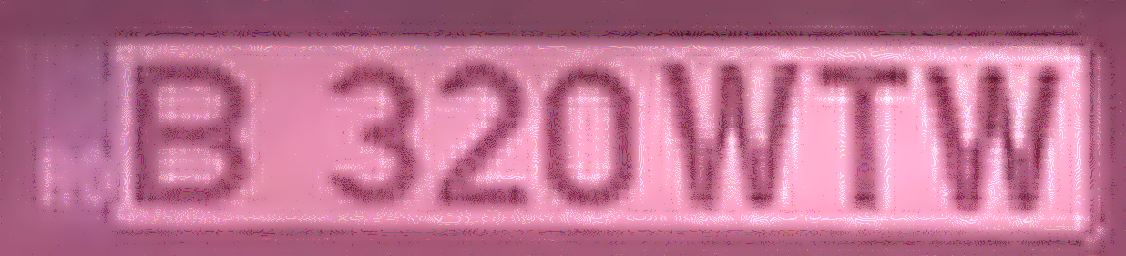

In [16]:
display(Image.fromarray(plate_result))

## Character segmentation using bounding boxes

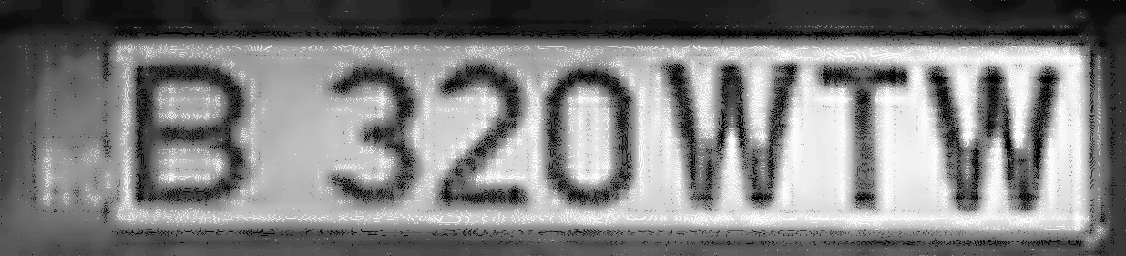

In [31]:
# Do some preprocessing on the license plate
histogram_eq_image = histogram_equalization(plate_result)
display(Image.fromarray(histogram_eq_image))

In [32]:
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(histogram_eq_image, kernel, iterations=1)

_, threshold = cv2.threshold(img_dilation, 150, 255, cv2.THRESH_TOZERO)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

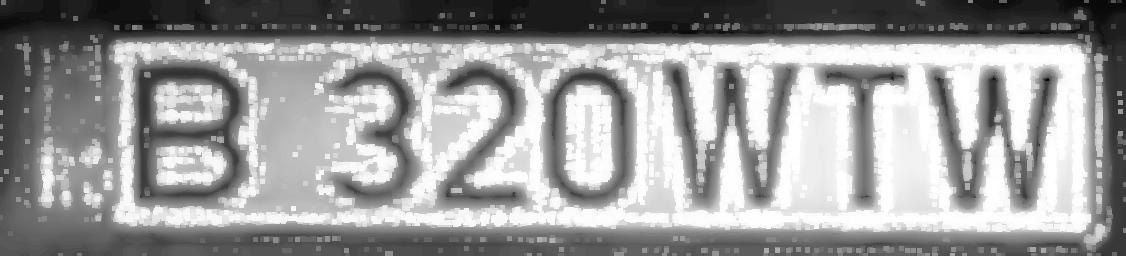

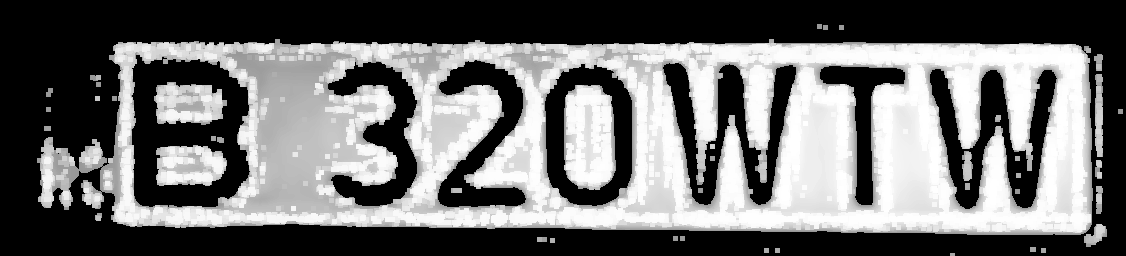

In [33]:
display(Image.fromarray(img_dilation))
display(Image.fromarray(threshold))

In [34]:
areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)
x, y = contours[max_area_idx].T
new_plate_bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))

In [35]:
cropped_plate_without_noise = threshold[max(new_plate_bbox[0][1], 0) : min(new_plate_bbox[1][1], threshold.shape[0]),
                                        max(new_plate_bbox[0][0], 0) : min(new_plate_bbox[1][0], threshold.shape[1])]

In [36]:
cropped_plate_without_noise_rgb = cv2.cvtColor(cropped_plate_without_noise,cv2.COLOR_GRAY2RGB) # This is not necessarry in the backend, just for debugging purposes

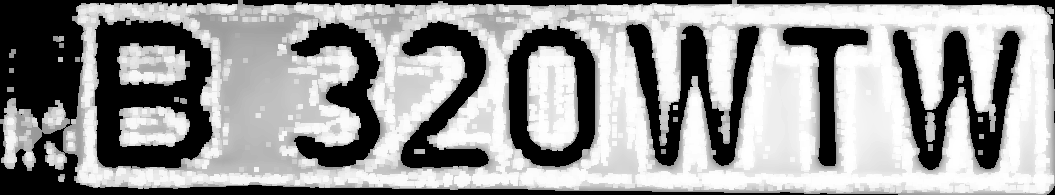

In [37]:
display(Image.fromarray(cropped_plate_without_noise))

In [38]:
contours, _ = cv2.findContours(cropped_plate_without_noise, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)

In [39]:
letters_bboxes = [areas.index(x) for x in sorted(areas, reverse=True)[:14]]
letters_bboxes.remove(max_area_idx)
print(f'letters_bboxes after removal is : {letters_bboxes}')

letters_bboxes after removal is : [29, 20, 12, 22, 26, 27, 21, 19, 33, 30, 17, 7, 28]


In [40]:
for idxs in letters_bboxes:
    x, y = contours[idxs].T
    bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
    backtorgb = cv2.rectangle(cropped_plate_without_noise_rgb, bbox[0], bbox[1], (255, 0, 0), 1)

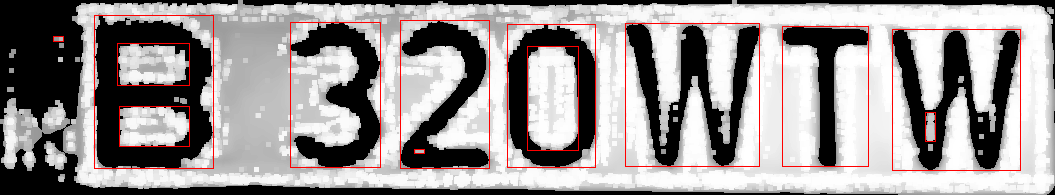

In [41]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

idxs = 29
 values = array([  0, 255], dtype=uint8)
 counts = array([11594,  6613], dtype=int64)


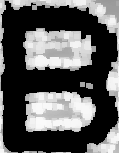

idxs = 20
 values = array([  0, 255], dtype=uint8)
 counts = array([6519, 6065], dtype=int64)


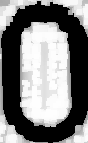

idxs = 12
 values = array([  0, 255], dtype=uint8)
 counts = array([8399, 9649], dtype=int64)


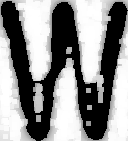

idxs = 22
 values = array([  0, 255], dtype=uint8)
 counts = array([ 8478, 10684], dtype=int64)


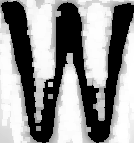

idxs = 26
 values = array([  0, 255], dtype=uint8)
 counts = array([6161, 6889], dtype=int64)


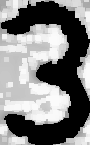

idxs = 27
 values = array([  0, 255], dtype=uint8)
 counts = array([6030, 7142], dtype=int64)


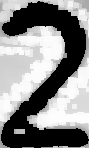

idxs = 21
 values = array([  0, 255], dtype=uint8)
 counts = array([ 905, 4399], dtype=int64)
idxs = 19
 values = array([  0, 255], dtype=uint8)
 counts = array([3935, 8105], dtype=int64)


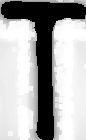

idxs = 33
 values = array([  0, 255], dtype=uint8)
 counts = array([ 971, 2053], dtype=int64)
idxs = 30
 values = array([  0, 255], dtype=uint8)
 counts = array([ 459, 2341], dtype=int64)
idxs = 17
 values = array([  0, 255], dtype=uint8)
 counts = array([ 99, 191], dtype=int64)
idxs = 7
 values = array([  0, 255], dtype=uint8)
 counts = array([30, 20], dtype=int64)
idxs = 28
 values = array([  0, 255], dtype=uint8)
 counts = array([ 8, 32], dtype=int64)


In [42]:
filtered_bboxes = []
for idxs in letters_bboxes:
    print(f'{idxs = }')
    x, y = contours[idxs].T
    bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
    character = cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])]
    
    _, thresholded_character = cv2.threshold(character, 175, 255, cv2.THRESH_BINARY)
    values, counts = np.unique(thresholded_character, return_counts=True)
    print(f' {values = }')
    print(f' {counts = }')
    if counts[0] > 2000 and counts[1] > (counts[0] / 2) and len(counts) > 1:
        display(Image.fromarray(character))
        filtered_bboxes.append(bbox)

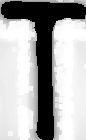

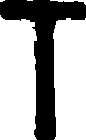

(array([  0, 255], dtype=uint8), array([3935, 8105], dtype=int64))

In [44]:
x, y = contours[19].T
bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
character = cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])]
display(Image.fromarray(character))
_, thresholded_character = cv2.threshold(character, 175, 255, cv2.THRESH_BINARY)
display(Image.fromarray(thresholded_character))
values, counts = np.unique(thresholded_character, return_counts=True)
values, counts

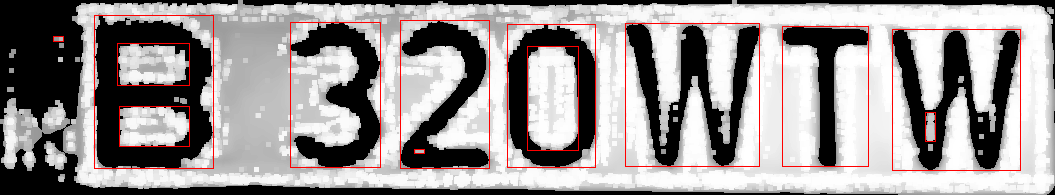

In [45]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

In [46]:
filtered_bboxes[0][0]

(94, 15)

In [47]:
cropped_plate_without_noise_rgb = cv2.circle(cropped_plate_without_noise_rgb, filtered_bboxes[0][0], radius=3, color=(0, 255, 255), thickness=-1)

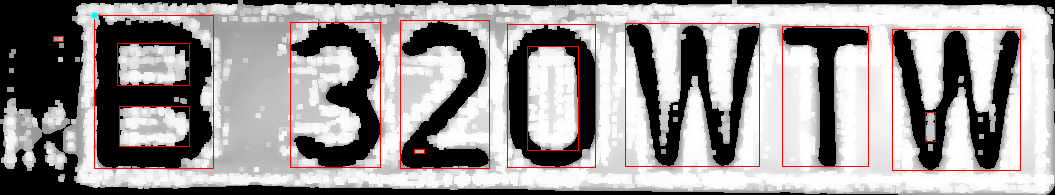

In [48]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

In [49]:
filtered_bboxes

[((94, 15), (213, 168)),
 ((507, 24), (595, 167)),
 ((892, 29), (1020, 170)),
 ((625, 23), (759, 166)),
 ((290, 22), (380, 167)),
 ((400, 20), (489, 168)),
 ((782, 26), (868, 166))]

In [50]:
filtered_bboxes = sorted(filtered_bboxes, key=lambda x: x[0][0])

In [51]:
filtered_bboxes

[((94, 15), (213, 168)),
 ((290, 22), (380, 167)),
 ((400, 20), (489, 168)),
 ((507, 24), (595, 167)),
 ((625, 23), (759, 166)),
 ((782, 26), (868, 166)),
 ((892, 29), (1020, 170))]

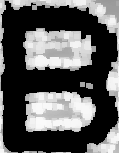

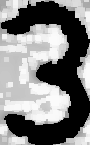

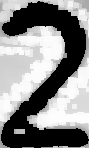

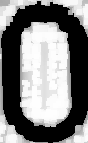

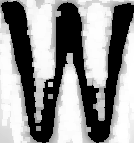

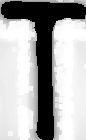

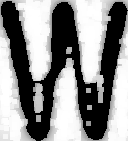

In [52]:
for bbox in filtered_bboxes:
    display(Image.fromarray(cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])]))

## Character classification based on bounding boxes

In [53]:
model_classificare = CharacterClassifier().to("cuda")
model_classificare.load_state_dict(torch.load(classification_model_path))
model_classificare.eval()

CharacterClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=196608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=35, bias=True)
)

In [54]:
raw_max_size = [195, 256]

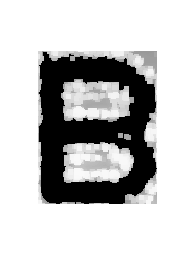

tensor([[-16.9680, -48.7662, -35.4833, -15.9216, -24.6025, -24.9005, -19.5125,
         -42.8766,  -6.1135,   4.2895, -15.2663,  28.0835, -64.9154,  -8.6494,
         -11.6314, -22.6557,  -7.1195, -10.5883, -43.5715, -26.4697, -40.5439,
         -33.2995, -17.8766, -12.3135, -33.1118,  -3.9312,  -3.8244,  -8.9554,
         -57.6872, -17.7609, -29.5204, -17.5819, -30.9509, -35.6427, -32.6369]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([11])


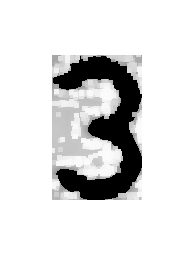

tensor([[ -5.8659,  -8.8165,   5.0301,  16.5347, -22.0661, -21.7379, -33.4154,
         -15.0520,  -2.2667,   0.4582, -24.2248,  -9.4558, -27.3609, -11.1367,
         -27.4919, -37.6868,  -5.5311, -51.5779, -34.3051, -11.3916, -52.4041,
         -39.8727, -30.9739, -28.9271,  -9.2813, -35.6071, -24.8411,  -5.0064,
         -15.3462, -35.3067, -20.4674, -36.1971, -14.6704, -31.3524, -10.9094]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([3])


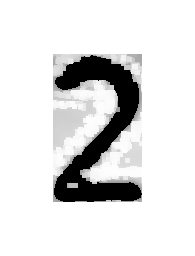

tensor([[-14.7155, -23.7502,  24.2651,   1.8130, -30.0291, -39.2265, -57.3680,
           4.3595, -21.0356,  -7.6701, -21.2970, -16.6704, -29.7091, -10.0335,
         -18.1248, -24.2077, -19.6527, -59.4773, -44.7952, -13.7105, -52.0866,
         -47.1498, -37.7121, -49.9199,  -8.7747, -20.9856, -22.0343, -16.1099,
         -17.8903, -36.0800, -16.9980, -45.4628, -10.5288, -28.1775,  -1.5852]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([2])


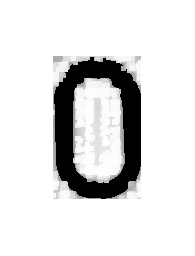

tensor([[ 14.5788,  -7.2036,  -9.9244, -30.0084, -16.5691, -26.7311, -10.2013,
         -18.6835,  -7.4003, -12.2403, -18.8688,  -8.1430,  -8.2808,  -2.3281,
         -23.2329, -27.9155,  -7.4276, -26.2813, -14.9434, -22.1077, -41.6778,
         -22.3845, -22.0395, -13.5721,   4.8555, -10.1025, -13.1595, -26.4134,
         -23.9625, -13.6907, -17.1671, -30.1872, -38.6393, -38.1148, -24.6708]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0])


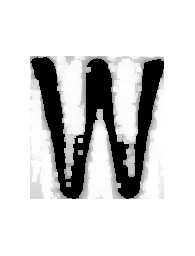

tensor([[ -5.9243, -13.8177, -34.5182,  -8.6849, -14.2117, -16.1374, -12.7077,
         -14.3148,  -3.3362,  -1.9122,  -1.5188,  -5.7947, -34.8135, -12.7041,
         -20.3127, -11.9417,  -6.2171,  -8.8530, -15.5020, -19.6688,  -0.6377,
         -25.4250,  -1.7156,   1.8666, -22.8569, -10.7714,  -3.7444, -11.8129,
         -24.2337, -14.1371,  -0.0416,  18.7094, -12.2310,  -4.0404, -16.1786]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([31])


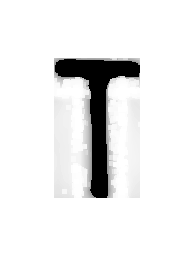

tensor([[-11.4529, -13.7968, -20.9101, -10.9840, -19.7436,  -8.4569, -24.6960,
          -0.5643, -22.7827, -19.9023, -32.1554, -29.4719,  -6.3175, -17.1107,
         -14.4113, -12.5877, -18.5583, -35.3542, -19.7036, -17.9501, -22.9469,
         -17.2528, -32.9289, -22.9873, -10.1050, -20.6471, -23.4611,  -4.5325,
          18.6430, -29.6307, -12.0810, -33.3866, -18.7830,  -4.1891, -11.1607]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([28])


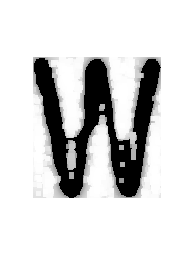

tensor([[ -6.2559, -14.4756, -35.2098,  -7.3214, -13.2861, -17.5926, -10.6006,
         -17.6291,  -0.6426,  -1.4850,  -0.2589,  -4.6120, -38.8436, -17.1750,
         -22.5550, -14.6743,  -4.6538,  -9.8127, -16.4392, -21.0453,   0.6839,
         -29.2373,   2.1727,   2.5353, -23.0426, -11.3839,  -1.0008, -13.8955,
         -28.9640, -16.1720,  -1.8340,  17.7338, -12.5368,  -6.2156, -18.5678]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([31])


In [55]:
license_plate_predicts_list = []
for bbox in filtered_bboxes:
    character = Image.fromarray(cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                            max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])])
    width, height = character.size

    x_axis_offset = (raw_max_size[0] - width) / 2
    y_axis_offset = (raw_max_size[1] - height) / 2
    new_width = width + int((2 * x_axis_offset))
    new_height = height + int((2 * y_axis_offset))

    result = Image.new(character.mode, (new_width, new_height), 255)
    result.paste(character, (int(x_axis_offset), int(y_axis_offset)))
    display(result)
    transform = transforms.Compose([transforms.ToTensor()])
    
    result = transform(result)
    result = result.unsqueeze(0)
    prediction = model_classificare(result.cuda())
    print(prediction)
    print(torch.argmax(prediction.cpu(), axis=1))
    license_plate_predicts_list.append(torch.argmax(prediction.cpu(), axis=1))

## License plate reconstruction as string